In [233]:
!pip install opencv-python

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [301]:
# Define a class to receive the characteristics of each line detection
class Line(object):
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
                        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
                
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None
        

In [308]:
class LineDetector(object):
    def __init__(self):
        self.src_points = np.float32([[270,675],
                 [580,460],
                 [700,460],
                 [1035,675]])
        self.dst_points = np.float32([[270,675],
                         [270,0],
                         [1035,0],
                         [1035,675]])
        
        self.left_line = Line()
        self.right_line = Line()
        
    def calibrate_cam(self):
        """
        Camera Calibration
        """

        # Read in and make a list of callibration images
        images = glob.glob('camera_cal/calibration*.jpg')

        # Arrays to store object points and image points for all images
        self.objpoints = []
        self.imgpoints = []
        
        # Prepare object points
        objp = np.zeros((6*9, 3), np.float32)
        objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

        for fname in images:
            img = mpimg.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
            if ret == True:
                self.imgpoints.append(corners)
                self.objpoints.append(objp)
        
        return (self.imgpoints, self.objpoints)
                
    def undistort_image(self, img):
        """
        Takes an image, object points, and image points performs the camera calibration, 
        image distortion correction and returns the undistorted image
        """
        # Use cv2.calibrateCamera() and cv2.undistort()
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
                                            self.objpoints, 
                                            self.imgpoints, 
                                            gray.shape[::-1], 
                                            None, 
                                            None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        return undist
    
    def threshold_image(self, img, s_thresh=(170, 255), sx_thresh=(20, 100)):
        img = np.copy(img)
        # Convert to HSV color space and separate the V channel
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        l_channel = hsv[:,:,1]
        s_channel = hsv[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        # Stack each channel
        # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
        # be beneficial to replace this channel with something else.
        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        return color_binary, combined_binary

    def perspective_transform(self, combined_binary):
        # Given src and dst points, calculate the perspective transform matrixes
        self.M = cv2.getPerspectiveTransform(self.src_points, self.dst_points)
        self.Minv = cv2.getPerspectiveTransform(self.dst_points, self.src_points)

        # Warp the image using OpenCV warpPerspective()
        self.img_size = (combined_binary.shape[1], combined_binary.shape[0])
        warped_image = cv2.warpPerspective(combined_binary, M, img_size)
        
        return warped_image

    def smoothing(self, lines, pre_lines=3):
        """
        *** REFACTOR ***
        """
        # collect lines & print average line
        lines = np.squeeze(lines)
        avg_line = np.zeros((720))

        for line in lines[-pre_lines:]:
            avg_line += line
        avg_line = avg_line / pre_lines

        return avg_line

    def detect_lane(self, binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        # And apply smoothing if array has enough values
        self.left_line.recent_xfitted.append(left_fitx)
        self.right_line.recent_xfitted.append(right_fitx)

        if len(self.left_line.recent_xfitted) > 10:
            # Left lines
            left_avg_line = self.smoothing(self.left_line.recent_xfitted, 10)
            left_avg_fit = np.polyfit(ploty, left_avg_line, 2)
            left_fit_plotx = left_avg_fit[0] * ploty ** 2 + left_avg_fit[1] * ploty + left_avg_fit[2]
            self.left_line.current_fit = left_avg_fit
            self.left_line.allx = left_fit_plotx
            self.left_line.ally = ploty
            
            # Right lines
            right_avg_line = self.smoothing(self.right_line.recent_xfitted, 10)
            right_avg_fit = np.polyfit(ploty, right_avg_line, 2)
            right_fit_plotx = right_avg_fit[0] * ploty ** 2 + right_avg_fit[1] * ploty + right_avg_fit[2]
            self.right_line.current_fit = right_avg_fit
            self.right_line.allx = right_fit_plotx
            self.right_line.ally = ploty

        else:
            # Left lines
            self.left_line.current_fit = left_fit
            self.left_line.allx = left_fitx
            self.left_line.ally = ploty
            
            # Right lines
            self.right_line.current_fit = right_fit
            self.right_line.allx = right_fitx
            self.right_line.ally = ploty

        self.left_line.detected = True
        self.right_line.detected = True
    
    def detect_lane_use_prev(self, binary_warped):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100

        left_current_fit = self.left_line.current_fit
        right_current_fit = self.right_line.current_fit

        # Identify the nonzero pixels in x and y within the window
        left_inds = ((nonzerox >= left_current_fit[0] * nonzeroy ** 2 + left_current_fit[1] * nonzeroy + left_current_fit[2] - margin) & (nonzerox <= left_current_fit[0] * nonzeroy ** 2 + left_current_fit[1] * nonzeroy + left_current_fit[2] + margin)).nonzero()[0]
        right_inds = ((nonzerox >= right_current_fit[0] * nonzeroy ** 2 + right_current_fit[1] * nonzeroy + right_current_fit[2] - margin) & (nonzerox <= right_current_fit[0] * nonzeroy ** 2 + right_current_fit[1] * nonzeroy + right_current_fit[2] + margin)).nonzero()[0]

        # Extract left and right line pixel positions
        leftx = nonzerox[left_inds]
        lefty = nonzeroy[left_inds]
        rightx = nonzerox[right_inds]
        righty =  nonzeroy[right_inds]

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

        # Add in array of previous lines
        self.left_line.recent_xfitted.append(left_fitx)
        self.right_line.recent_xfitted.append(right_fitx)

        leftx_avg = np.average(left_fitx)
        rightx_avg = np.average(right_fitx)

        # And apply smoothing if array has enough values
        if len(self.left_line.recent_xfitted) > 10:
            # Left lines
            left_avg_line = self.smoothing(self.left_line.recent_xfitted, 10)
            left_avg_fit = np.polyfit(ploty, left_avg_line, 2)
            left_fit_plotx = left_avg_fit[0] * ploty ** 2 + left_avg_fit[1] * ploty + left_avg_fit[2]
            self.left_line.current_fit = left_avg_fit
            self.left_line.allx = left_fit_plotx
            self.left_line.ally = ploty
            
            # Right lines
            right_avg_line = self.smoothing(self.right_line.recent_xfitted, 10)
            right_avg_fit = np.polyfit(ploty, right_avg_line, 2)
            right_fit_plotx = right_avg_fit[0] * ploty ** 2 + right_avg_fit[1] * ploty + right_avg_fit[2]
            self.right_line.current_fit = right_avg_fit
            self.right_line.allx = right_fit_plotx
            self.right_line.ally = ploty
        else:
            # Left lines
            self.left_line.current_fit = left_fit
            self.left_line.allx = left_fitx
            self.left_line.ally = ploty
            
            # Right lines
            self.right_line.current_fit = right_fit
            self.right_line.allx = right_fitx
            self.right_line.ally = ploty
            
        # Do lane line detection from scratch if std of r-l line distance is high
        line_std = np.std(self.right_line.allx - self.left_line.allx)

        if (line_std > 80):
            self.left_line.detected = False
            self.right_line.detected = False

    def get_curvature_position(self):
        ploty = self.left_line.ally
        leftx = self.left_line.allx
        rightx = self.right_line.allx
        leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
        rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

        # Define conversions in x and y from pixels space to meters
        width_lanes = abs(self.right_line.allx[-1] - self.left_line.allx[-1])
        self.ym_per_pix = 30 / 720  # meters per pixel in y dimension
        self.xm_per_pix = 3.7*(720/1280) / width_lanes  # meters per pixel in x dimension

        # Define y-value where we want radius of curvature
        # the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        self.left_line.radius_of_curvature = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
        self.right_line.radius_of_curvature = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
    
    def draw_image(self, image, warped_image):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_image).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.left_line.allx, self.left_line.ally]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_line.allx, self.right_line.ally])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
        # Calculate lane center, left + rightline intercept on x axis
        left_fit = self.left_line.current_fit
        right_fit = self.right_line.current_fit
        left_intcpt = left_fit[0] * img_size[1]**2 + left_fit[1] * img_size[1] + left_fit[2]
        right_intcpt = right_fit[0] * img_size[1]**2 + right_fit[1] * img_size[1] + right_fit[2]
        lane_center = (left_intcpt + right_intcpt)/2.0
        car_deviation = (lane_center - self.img_size[0]/2.0) * self.xm_per_pix

        # Draw numbers on image
        left_curve_txt = 'Left Curvature = {} m'.format(np.round(self.left_line.radius_of_curvature, 2)) 
        right_curve_txt = 'Right Curvature = {} m'.format(np.round(self.right_line.radius_of_curvature,2)) 
        car_dev_txt = 'Vehicle off center by {} m'.format(np.round(car_deviation,2))

        cv2.putText(result, left_curve_txt, (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
        cv2.putText(result, right_curve_txt, (30, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
        cv2.putText(result, car_dev_txt, (30, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)

        return result
    
    def pipeline(self, image):
        # Undistort image
        undistorted_img = self.undistort_image(image)
        
        # Apply binary threshold
        color_binary, combined_binary = self.threshold_image(undistorted_img)
        
        # Apply perspective transform
        warped_image = self.perspective_transform(combined_binary)
        
        # Detect left and right lines - decide whether to use previous frame or start calculation from scratch
        if self.left_line.detected:
            self.detect_lane_use_prev(warped_image)
        else:
            self.detect_lane(warped_image)
        
        # Calculate curvature
        self.get_curvature_position()

        # Draw curvature and off-center car distance on image
        result = self.draw_image(image, warped_image)
        
        return result

line_detector = LineDetector()

# 1.Calibrate camera

In [273]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline


# Read in and make a list of callibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store object points and image points for all images
objpoints = []
imgpoints = []

# Prepare object points
objp = np.zeros((6*9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

# Callibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


# 2.Apply distortion correction to raw images

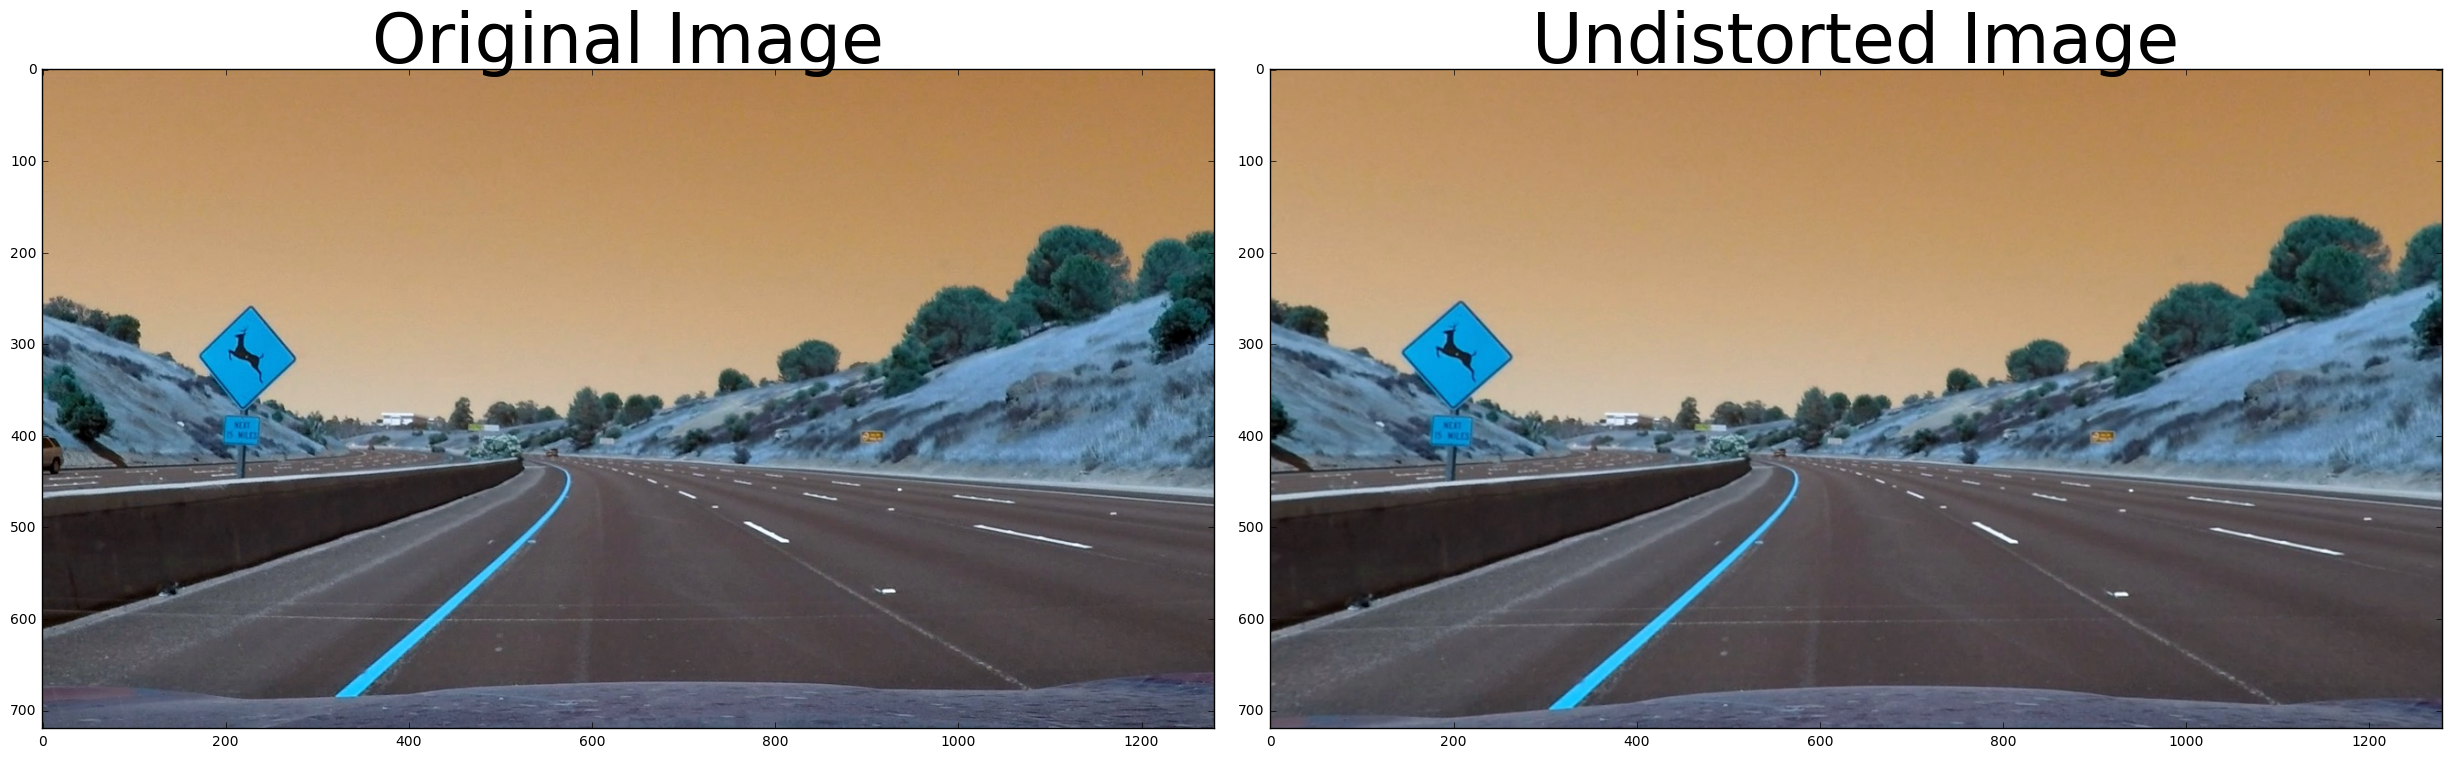

In [274]:
# Read in an image
img = cv2.imread('test_images/test2.jpg')

def cal_undistort(img, objpoints, imgpoints):
    """
    Takes an image, object points, and image points performs the camera calibration, 
    image distortion correction and returns the undistorted image
    """
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
                                        objpoints, 
                                        imgpoints, 
                                        gray.shape[::-1], 
                                        None, 
                                        None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# 3.Create threshold binary image (with color transformations and gradient descent)

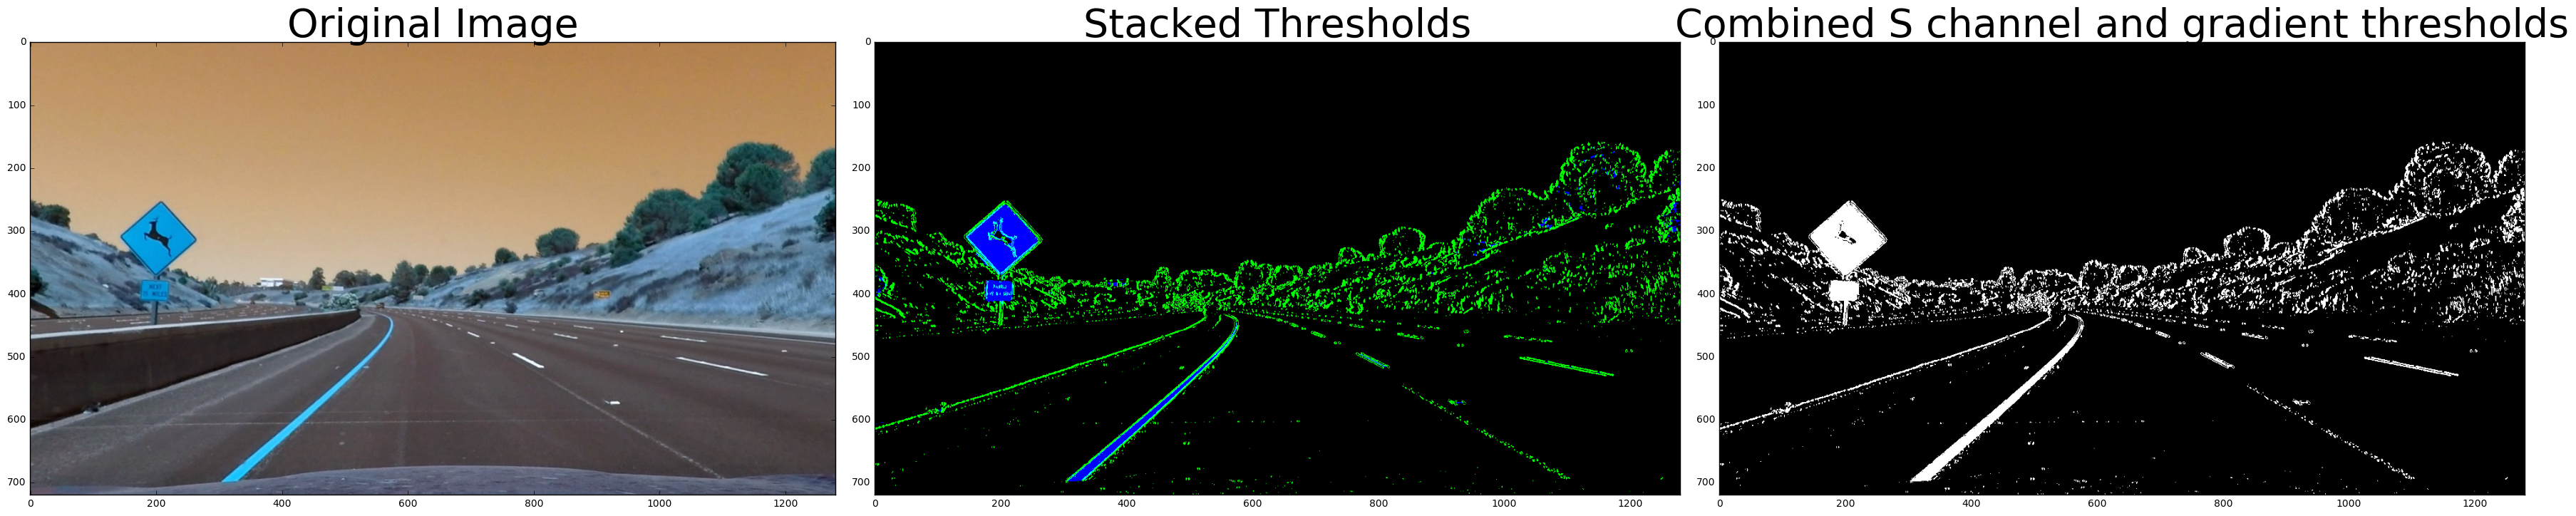

In [275]:
image = undistorted

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary
    
color_binary, combined_binary = pipeline(image)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(35, 10))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(color_binary)
ax2.set_title('Stacked Thresholds', fontsize=40)

ax3.imshow(combined_binary, cmap='gray')
ax3.set_title('Combined S channel and gradient thresholds', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# 4.Apply a perspective transform to rectify binary image (bird's view)

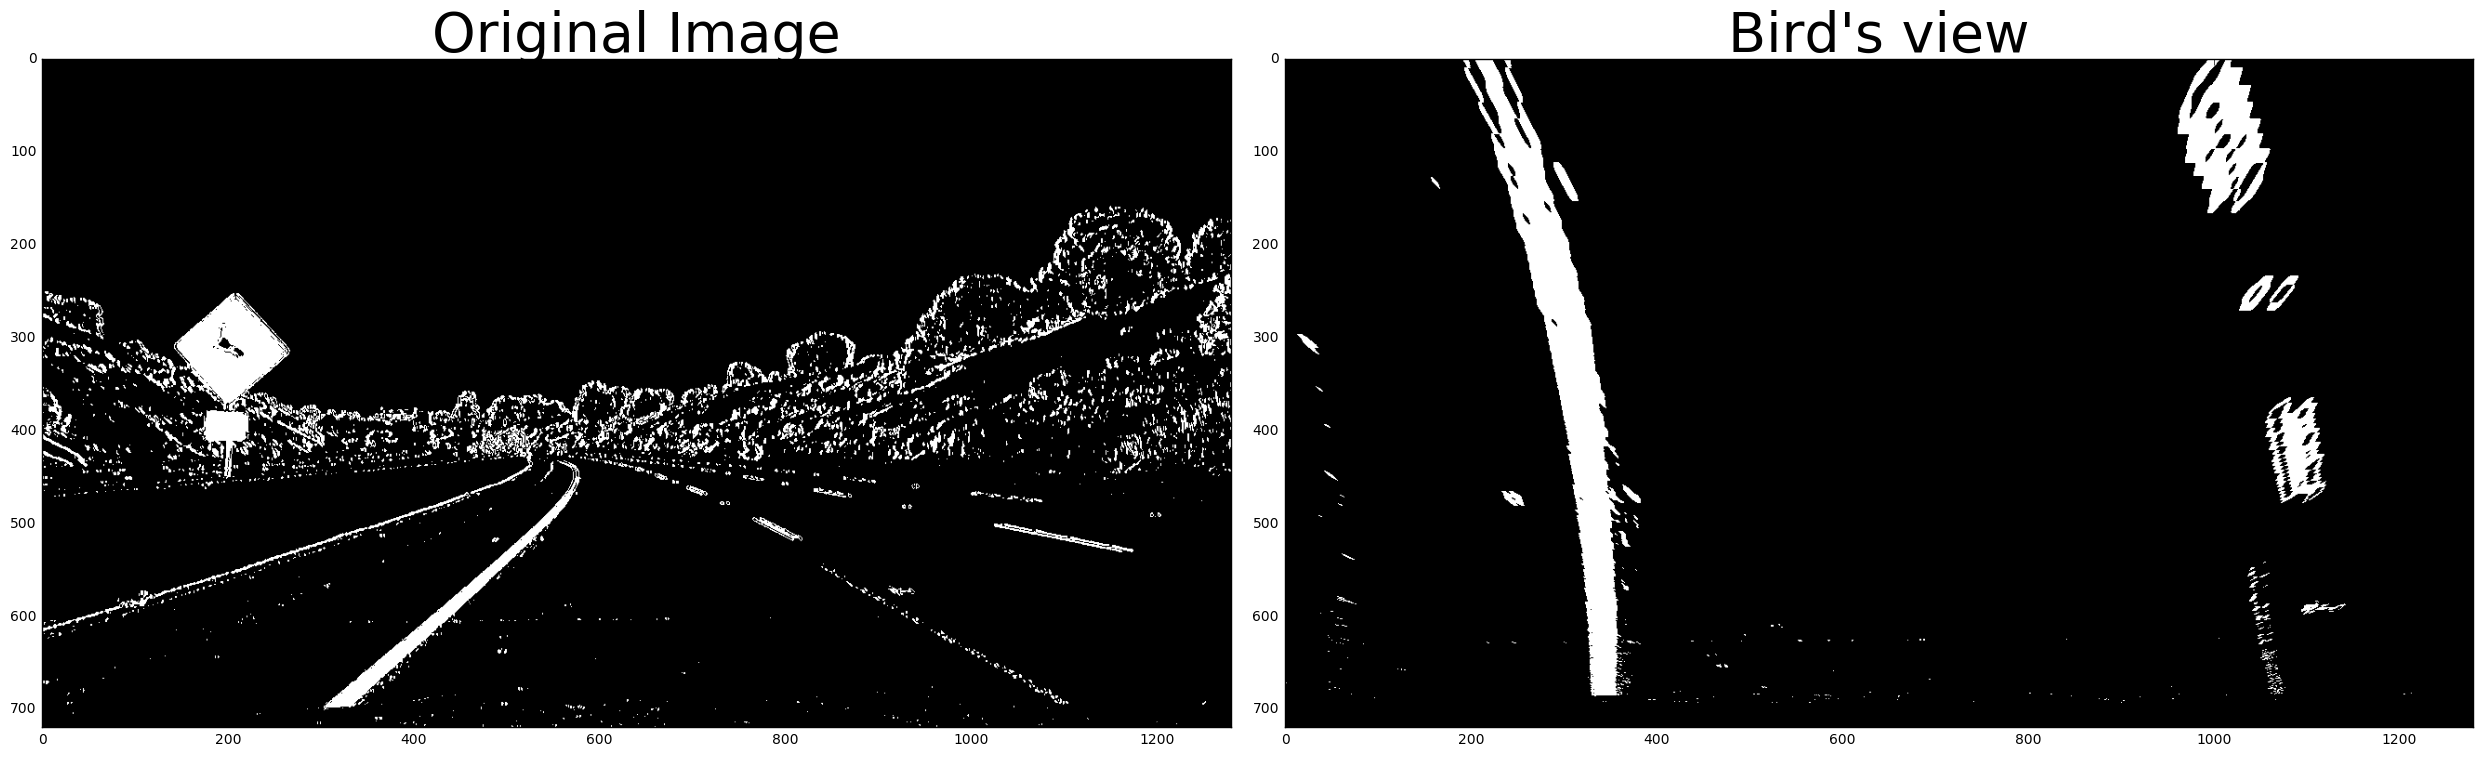

In [276]:
src = np.float32([[270,675],
                 [580,460],
                 [700,460],
                 [1035,675]])
dst = np.float32([[270,675],
                 [270,0],
                 [1035,0],
                 [1035,675]])

# Given src and dst points, calculate the perspective transform matrixes
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the image using OpenCV warpPerspective()
img_size = (combined_binary.shape[1], combined_binary.shape[0])
warped_image = cv2.warpPerspective(combined_binary, M, img_size)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped_image, cmap='gray')
ax2.set_title("Bird's view", fontsize=40)

# 5.Detect lane pixels and fit to find the lane boundary

(720, 0)

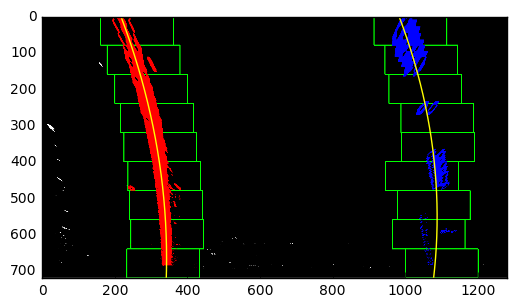

In [277]:
binary_warped = warped_image

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

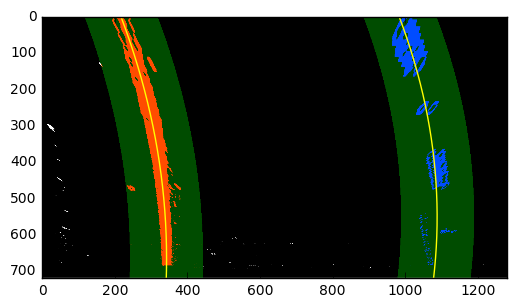

In [278]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# 6.Determine the curvature of the lane and vehicle position with respect to center

In [279]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

1766.67386192 1483.78678212


In [280]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
print("Left: {} m | Right: {} m".format(left_curverad, right_curverad))

Left: 579.4632874376063 m | Right: 477.90837576030464 m


# 7.Warp the detected lane boundaries back onto the original image

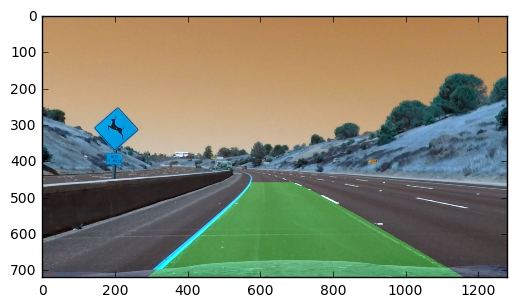

In [281]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped_image).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

plt.imshow(result)


# 8.Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

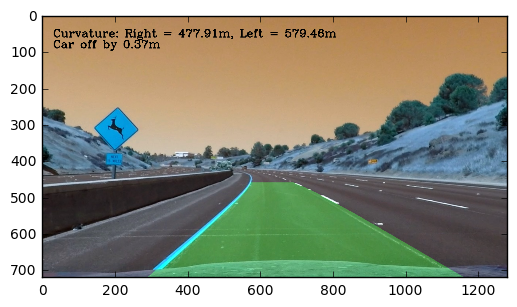

In [282]:
# calculate lane midpoint
# left line intercept on x axis
left_intcpt = left_fit[0]*img_size[1]**2 + left_fit[1]*img_size[1] + left_fit[2]

# right line intercept on x axis
right_intcpt = right_fit[0]*img_size[1]**2 + right_fit[1]*img_size[1] + right_fit[2]
lane_mid = (left_intcpt + right_intcpt)/2.0
car_off = (lane_mid - img_size[0]/2.0)*xm_per_pix

def display_on_frame(image, left_curverad, right_curverad, car_off):
    """
    Display texts on image using passed values
    """
    # create display texts on image
    font = cv2.FONT_HERSHEY_COMPLEX
    curve_disp_txt = 'Curvature: Right = ' + str(np.round(right_curverad,2)) + 'm, Left = ' + str(np.round(left_curverad,2)) + 'm' 

    off_disp_txt = 'Car off by ' + str(np.round(car_off,2)) + 'm'
    final = image
    cv2.putText(final, curve_disp_txt, (30, 60), font, 1, (0,0,0), 2)
    cv2.putText(final, off_disp_txt, (30, 90), font, 1, (0,0,0), 2)
    
    return final

final = display_on_frame(result, left_curverad=left_curverad, right_curverad=right_curverad,
                        car_off=car_off)
plt.imshow(final)

# Run pipeline

In [309]:
line_detector.calibrate_cam()

([array([[[  88.67900848,  138.3946228 ]],
  
         [[ 118.19707489,  135.54194641]],
  
         [[ 148.45201111,  132.91802979]],
  
         [[ 179.9763031 ,  129.96759033]],
  
         [[ 212.91256714,  127.26237488]],
  
         [[ 247.25083923,  124.24643707]],
  
         [[ 285.02120972,  121.58181   ]],
  
         [[ 324.04864502,  119.01935577]],
  
         [[ 364.38803101,  116.23473358]],
  
         [[  88.6996994 ,  182.51835632]],
  
         [[ 116.89981842,  180.89904785]],
  
         [[ 145.67886353,  178.9223175 ]],
  
         [[ 176.58163452,  176.98924255]],
  
         [[ 208.89482117,  175.12263489]],
  
         [[ 244.99610901,  173.74353027]],
  
         [[ 283.13766479,  172.36987305]],
  
         [[ 322.6053772 ,  170.9158783 ]],
  
         [[ 363.13571167,  169.55879211]],
  
         [[  87.52413177,  226.77748108]],
  
         [[ 114.50705719,  225.90542603]],
  
         [[ 143.56080627,  225.18487549]],
  
         [[ 173.85424805,  224.587

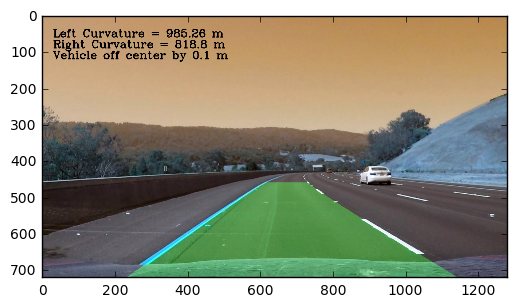

In [307]:
img = cv2.imread('test_images/test3.jpg')
result = line_detector.pipeline(img)

plt.imshow(result)

# Create video

In [90]:
!pip install moviepy

    100% |████████████████████████████████| 112kB 2.4MB/s ta 0:00:01
    100% |████████████████████████████████| 3.3MB 330kB/s eta 0:00:01   21% |███████                         | 716kB 6.6MB/s eta 0:00:01    68% |██████████████████████          | 2.3MB 16.9MB/s eta 0:00:01    92% |█████████████████████████████▋  | 3.1MB 16.5MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 9.4MB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 9.4MB/s eta 0:00:01
  Running setup.py bdist_wheel for moviepy ... - \ | done
  Stored in directory: /home/jovyan/.cache/pip/wheels/d5/45/2d/dcf42b576910d66bdd81191d94398f46b89efd3d4eaf91ceca
  Running setup.py bdist_wheel for imageio ... - \ done
  Stored in directory: /home/jovyan/.cache/pip/wheels/47/a7/c8/2d9d42949793f2ad22a9f7974be42b34f77b97d28aa206cf94
  Running setup.py bdist_wheel for olefile ... - \ done
  Stored in directory: /home/jovyan/.cache/pip/wheels/20/58/49/cc7bd00345397059149a10b0259ef38b867935ea2ec

In [94]:
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0%)524288/28549024 bytes (1.8%)1392640/28549024 bytes (4.9%)2727936/28549024 bytes (9.6%)4571136/28549024 bytes (16.0%)6365184/28549024 bytes (22.3%)8413184/28549024 bytes (29.5%)10010624/28549024 bytes (35.1%)11780096/28549024 bytes (41.3%)13836288/28549024 bytes (48.5%)16097280/28549024 bytes (56.4%)18014208/28549024 bytes (63.1%)20062208/28549024 bytes (70.3%)22044672/28549024 bytes (

In [95]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [254]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip("project_video.mp4", 20, 26, targetname="test20.mp4")


[MoviePy] Running:
>>> /home/jovyan/.imageio/ffmpeg/ffmpeg.linux64 -y -i project_video.mp4 -ss 20.00 -t 6.00 -vcodec copy -acodec copy test20.mp4
... command successful.


In [310]:
pv_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(line_detector.pipeline)
%time white_clip.write_videofile(pv_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:01<23:39,  1.13s/it]


  0%|          | 2/1261 [00:02<23:58,  1.14s/it]


  0%|          | 3/1261 [00:03<24:06,  1.15s/it]


  0%|          | 4/1261 [00:04<24:09,  1.15s/it]


  0%|          | 5/1261 [00:05<24:09,  1.15s/it]


  0%|          | 6/1261 [00:06<24:14,  1.16s/it]


  1%|          | 7/1261 [00:08<24:13,  1.16s/it]


  1%|          | 8/1261 [00:09<24:14,  1.16s/it]


  1%|          | 9/1261 [00:10<24:16,  1.16s/it]


  1%|          | 10/1261 [00:11<24:19,  1.17s/it]


  1%|          | 11/1261 [00:12<24:19,  1.17s/it]


  1%|          | 12/1261 [00:13<24:19,  1.17s/it]


  1%|          | 13/1261 [00:15<24:18,  1.17s/it]


  1%|          | 14/1261 [00:16<24:18,  1.17s/it]


  1%|          | 15/1261 [00:17<24:16,  1.17s/it]


  1%|▏         | 16/1261 [00:18<24:12,  1.17s/it]


  1%|▏         | 17/1261 [00:19<24:13,  1.17s/it]


  1%|▏         | 18/1261 [00:20<24:08,  1.17s/it]


  2%|▏         | 19/1261 [0

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 22min 30s, sys: 1min 33s, total: 24min 4s
Wall time: 26min 14s


In [98]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video.mp4'))